# Paper Section: Fig 1 in Results

Following these analysis, we observe that a good fit requires at least a few data points at the linear range. Thus, the worklfow for generating learning curves can be as follows. That is particularly efficient sequential processing.
1. Start with the largest training subset, and proceed to smaller subsets with a pre-defined step size.
2. Generate at least 4 learning curve points and fit power-law. Record RMSE (goodness-of-fit).
3. Starting from the 5th point (that's a heuristic), fit a power-law to the existing learning curve points. If the fit does not improve, as measured by RMSE, we terminate the workflow.

Notes:<br>
We evaluate the quality (usefulness) of fit with two measures:
1. RMSE
2. Ability to extrapolate

Question:
1. Why plots generated by LGBM and RF are so consistent across runs?? Is it because we use the same random_state??

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from glob import glob

import matplotlib
import matplotlib.pyplot as plt

# Make all python scripts available in the path
sys.path.append('../')

import pp_utils
import lrn_crv_plot
%matplotlib inline

filepath = Path(os.getcwd())
print(filepath)

/vol/ml/apartin/projects/LearningCurves/notebooks


In [2]:
save_fig_path = filepath/'figs'

### Get dir path of all runs

In [3]:
# src = 'gdsc'
# src = 'ctrp'
src = 'top6_on_cell'
# src = 'top21'

# Runs dir
# CCLE - very small difference when usgin default and LS-best HPs to generate LC
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ccle/split_on_none/multi_seed_no-HPO')
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ccle/split_on_none/multi_seed_LS-Best')

# GDSC
if src=='gdsc':
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_lgbm_100_trees_no_hpo')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_lgbm_1000_trees_no_hpo')    
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_rf_100_trees_no_hpo')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_rf_1000_trees_no_hpo')
    
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_lgbm_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_cell/multi_seed_rf_100_trees')

# CTRP - the fit default hps is not good; 
elif src=='ctrp':
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_lgbm_100_trees_no_hpo')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_lgbm_1000_trees_no_hpo')    
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_rf_100_trees_no_hpo')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/split_on_cell/multi_seed_rf_1000_trees_no_hpo') # not ready

elif src=='top6_on_cell':
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_cell/multi_seed_lgbm_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_cell/multi_seed_rf_100_trees')
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_cell/nn_reg_ap')
    
elif src=='top21':    
    # base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top21/split_on_cell/multi_seed_lgbm_100_trees')
    base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.top21/split_on_cell/multi_seed_rf_100_trees')
    
    
# Get all run dirs
runs = glob(str(base_dir/'*'))

### Aggregate results over runs

In [4]:
scores = []
for i, r in enumerate(runs):
    # scr_tmp = pd.read_csv( Path(r)/'lrn_crv_scores.csv' )
    dpath = Path(r)/'lrn_crv_scores.csv'
    if not dpath.exists(): continue
        
    scr_tmp = pd.read_csv( dpath )
    scr_tmp.rename(columns={'fold0': 'run'+str(i+1)}, inplace=True)
    if len(scores)==0:
        scores = scr_tmp
    else:
        scores = scores.merge(scr_tmp, on=['metric', 'tr_size', 'set'])
        
run_col_names = [c for c in scores.columns if 'run' in c]

scores_mean   = scores[run_col_names].mean(axis=1)
scores_median = scores[run_col_names].median(axis=1)
scores_std    = scores[run_col_names].std(axis=1)

scores.insert(loc=3, column='mean', value=scores_mean)
scores.insert(loc=3, column='median', value=scores_median)
scores.insert(loc=3, column='std', value=scores_std)

display(scores[:2])
print('Training set sizes:', np.unique(scores.tr_size))

save = True
if save:
    scores.to_csv(base_dir/'all_seed_runs_scores.csv', index=False)

,metric,tr_size,set,std,median,mean,run2,run3,run4,run5,...,run12,run13,run14,run15,run16,run17,run18,run19,run20,run21
0,mean_absolute_error,128,tr,0.012714,0.060924,0.061988,0.060981,0.072062,0.042303,0.073678,...,0.060867,0.078482,0.054201,0.064018,0.057531,0.047588,0.054468,0.060520,0.043078,0.078246
1,mean_absolute_error,256,tr,0.016047,0.047698,0.048663,0.043528,0.045333,0.021320,0.079424,...,0.061930,0.032332,0.069651,0.057386,0.029986,0.060575,0.056598,0.041476,0.037512,0.072612


Training set sizes: [   128    256    512   1024   2048   4096   8192  16384  32768  65536
 131072 213019]


In [5]:
scores_te = scores[(scores.metric=='mean_absolute_error') & (scores.set=='te')].reset_index(drop=True).iloc[:, :6]
scores_te.to_csv(base_dir/'scores.csv', index=False)

# Fig 1a LC on lin-lin scale
Generated using GBDT for multiple data shuffles of GDSC.

In [6]:
figsize = (6, 4.5)
metric_name = 'mean_absolute_error'
tr_set = 'te'

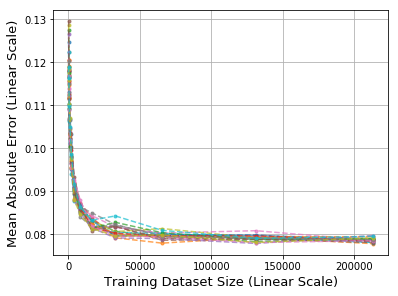

In [7]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'linear', 'ytick_scale': 'linear'}
shard_min_idx=0
# shard_min_idx=1

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=shard_min_idx, **plot_args );
plt.savefig(save_fig_path/f'{src}_all_runs_linlin_scale.png')

# Fig 1b LC on log-log scale
Generated using GBDT for multiple data shuffles of GDSC.

- When data is presented on log-log scale, it is easier to discriminate between the different regions of model improvement.

Other comments:<br>
- Certain shuffles generate data that does not result in a successful power law fit when all points are used.
- As a result, we generate data for multiple seeds and aggregate across runs via median.
- Then, we fit a power law to the aggregated LC data.

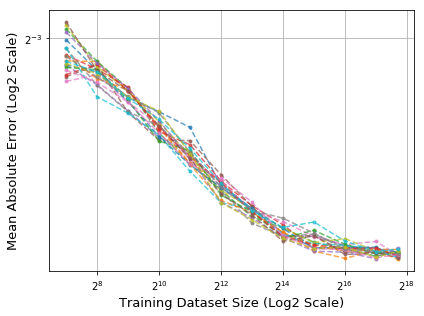

In [8]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'log2', 'ytick_scale': 'log2'}
shard_min_idx=0
# shard_min_idx=1

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=shard_min_idx, **plot_args );
plt.tight_layout()
plt.savefig(save_fig_path/f'{src}_all_runs_loglog_scale.png')

# Fig 1c LC of Median and STD across all shuffles

- STD of scores across runs is inversely proportional to the subset size. This can be attributed to the distribution similarity of target values between training subset and test set. The target values, is our use case, are the dose-independent values. The smaller the subset, the lower the similarity with a test set, and therefore, we observe larger variance of scores across runs [shuffles/experiments] at smaller subsets.
- We exploit this observation for ... [Mukherjee exploits this observation ...]

In [9]:
figsize = (6, 4.5)
# figsize = (10, 8)
metric_name = 'mean_absolute_error'
xtick_scale, ytick_scale = 'log2', 'log2'

plot_args = {'metric_name': metric_name, 'xtick_scale': xtick_scale, 'ytick_scale': xtick_scale, 'figsize': figsize}

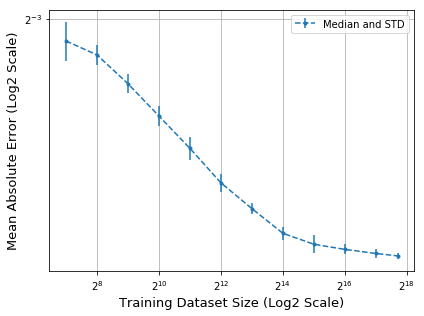

In [10]:
scores_te = scores[ (scores['metric']==metric_name) & (scores['set']=='te') ].reset_index(drop=True)

shard_min_idx=0
# shard_min_idx=1

ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][shard_min_idx:], y=scores_te['median'][shard_min_idx:], yerr=scores_te['std'][shard_min_idx:],
        ax=ax, ls='--', marker='.', alpha=1,
        **plot_args, label='Median and STD')

ax.legend(frameon=True, fontsize=10, loc='best');
plt.tight_layout()
plt.savefig(save_fig_path/f'{src}_agg_median_std.png')

# Fig 2a Power-law fit to all LC data

GOF: {'rmse': 0.001940779704194999, 'mae': 0.0017623414294776856}


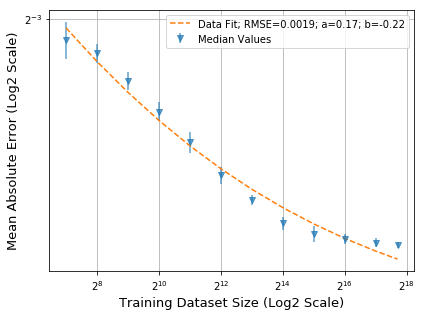

In [11]:
ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][0:], y=scores_te['median'][0:], yerr=scores_te['std'][0:],
        ax=ax, ls='', marker='v', alpha=0.7,
        **plot_args, label='Median Values')

shard_min_idx = 0
ax, _, gof = lrn_crv_plot.plot_lrn_crv_power_law(
        x=scores_te['tr_size'][shard_min_idx:], y=scores_te['median'][shard_min_idx:],
        **plot_args, plot_raw=False, ax=ax, alpha=1);

ax.legend(frameon=True, fontsize=10, loc='best')
plt.tight_layout()
plt.savefig(save_fig_path/f'{src}_agg_median_std_fit_all_points.png')

print('GOF:', gof)

# Fig 2b Power-law fit to a subset all LC data

- The fit improves (smaller RMSE) by exclusing some of the initial points.
- We also observe that better fits result in better agreement with the theoretical values of the power-fit. Specifically, the value of beta.

4
GOF: {'rmse': 0.0003749186695176978, 'mae': 0.0003272006788435592}


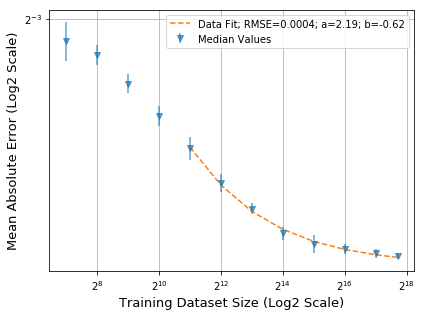

In [18]:
tot_pnts = len(scores_te['tr_size'])
n_pnts_fit = 8 # Number of points to use for curve fitting starting from the largest size

y_col_name = 'median'

ax = None

ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][0:], y=scores_te[y_col_name][0:], yerr=scores_te['std'][0:],
        ax=ax, ls='', marker='v', alpha=0.7,
        **plot_args, label='Median Values')

shard_min_idx = 0 if tot_pnts < n_pnts_fit else tot_pnts - n_pnts_fit

ax, _, gof = lrn_crv_plot.plot_lrn_crv_power_law(
        x=scores_te['tr_size'][shard_min_idx:], y=scores_te[y_col_name][shard_min_idx:],
        **plot_args, plot_raw=False, ax=ax, alpha=1 );

ax.legend(frameon=True, fontsize=10, loc='best')
plt.tight_layout()
plt.savefig(save_fig_path/f'{src}_agg_median_std_fit_subset_points.png')

print('GOF:', gof)

### Fig 2c MAE as a function of LC points

The workflow is to go backwards. We fit a power-law after every time we compute score for consecutive (smaller) shard. Stop when quality of fit decreases.

tot_pnts 12


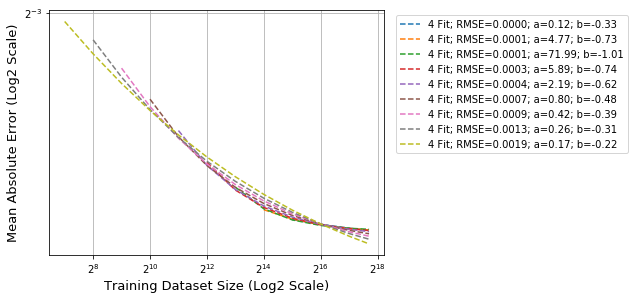

In [36]:
tot_pnts = len(scores_te['tr_size'])
print('tot_pnts', tot_pnts)
# min_points = 3 # 3 points doesn't work
min_pnts_fit = 4
# max_pnts = 9
max_pnts_fit = tot_pnts

p_arr = []
# rmse_arr = []
gof_arr = []
prm_arr = []
ax = None
for n_pnts_fit in range(min_pnts_fit, max_pnts_fit+1):
# for shard_min_idx in range(tot_points - min_points + 1):
    # n_points = tot_points - shard_min_idx
    shard_min_idx = tot_pnts - n_pnts_fit
    
    ax, prm, gof = lrn_crv_plot.plot_lrn_crv_power_law(
            x=scores_te['tr_size'][shard_min_idx:], y=scores_te['median'][shard_min_idx:],
            **plot_args, ax=ax, plot_raw=False, label=str(n_pnts) );
    
    prm_arr.append(prm)
    gof_arr.append(gof)
    p_arr.append(n_pnts_fit)
    
# ax.legend(frameon=True, fontsize=10, loc='best');

# idx = np.array(rmse_arr).argmin()
# p_arr[idx]

In [37]:
prm_df = pd.DataFrame(prm_arr)
gof_df = pd.DataFrame(gof_arr)
n_pnts_df = pd.DataFrame({'n_pnts': p_arr})
dd = pd.concat([n_pnts_df, gof_df, prm_df], axis=1)

display(dd.sort_values('mae'))

The plot below can go to a table!

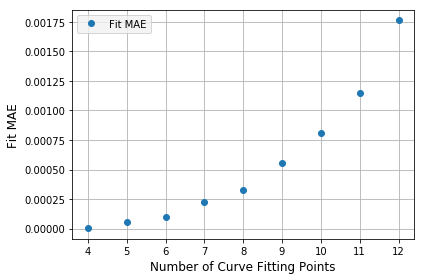

In [39]:
plot_beta = False

fig, ax1 = plt.subplots()

# Plot metrics
alpha = 0.6
linewidth = 1
fontsize = 12
lns1 = ax1.plot(dd.n_pnts, dd.mae, marker='o', ls='', label='Fit MAE');
ax1.set_xlabel('Number of Curve Fitting Points', fontsize=fontsize)
ax1.set_ylabel('Fit MAE', fontsize=fontsize)
ax1.tick_params('y', colors='k')

leg = lns1

if plot_beta:
    ax2 = ax1.twinx()
    lns2 = ax2.plot(dd.n_pnts, dd.beta, color='m', marker='*', ls='', label='Fit Parameter $b$')
    ax2.set_ylabel('Fit Parameter $b$ in $am^{b} + c$', color='k', fontsize=fontsize)
    ax2.tick_params('y', colors='k')
    leg.append(lns2)
        
ax1.grid(True)

# leg = lns1 + lns2
labs = [l.get_label() for l in leg]
legend = ax1.legend(leg, labs, loc=0)
frame = legend.get_frame()
frame.set_facecolor('0.95')
plt.tight_layout()

plt.savefig(save_fig_path/f'{src}_mae_prm_b_num_points.png')

# Fig 3a Extrapolate

tot_pnts 12


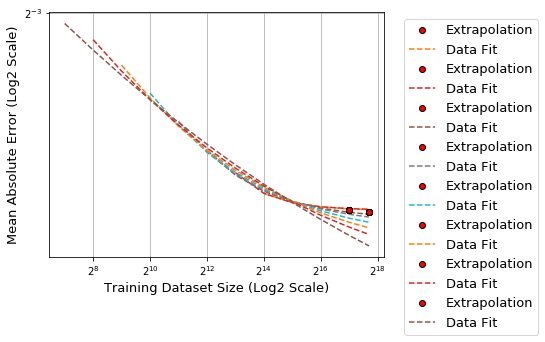

In [47]:
scr = scores_te.copy()
# scr = scores_te.copy().iloc[:-5, :]

# plot_args['figsize'] = (10, 8)
plot_args['figsize'] = (6, 4.5)

n_pnts_ext = 2 # Number of points to extrapolate to
n_pnts_fit = 6 # Number of points to use for curve fitting starting from the largest size

tot_pnts = len(scr['tr_size'])
m0 = tot_pnts - n_pnts_ext  # The adjusted number of available LC points
shard_min_idx = m0 - n_pnts_fit
# ---------------------------------------------


tot_pnts = len(scores_te['tr_size'])
print('tot_pnts', tot_pnts)
min_pnts_fit = 3 # 3 points doesn't work
# min_pnts_fit = 4
# max_pnts = 9
max_pnts_fit = m0 # tot_pnts

p_arr = []
gof_arr = []
prm_arr = []
ax = None
for n_pnts_fit in range(min_pnts_fit, max_pnts_fit+1):
    shard_min_idx = m0 - n_pnts_fit
    
    # Extrapolation
    ax, _, gof = lrn_crv_plot.lrn_crv_power_law_extrapolate(
            x = scr['tr_size'][shard_min_idx:], y = scr['median'][shard_min_idx:],
            n_pnts_ext = n_pnts_ext,
            **plot_args, plot_raw_it=False, label_et='Extrapolation', ax=ax );    
    
    prm_arr.append(prm)
    gof_arr.append(gof)
    p_arr.append(n_pnts_fit)
    
# ax.legend(frameon=True, fontsize=10, loc='best');

# idx = np.array(rmse_arr).argmin()
# p_arr[idx]

In [48]:
prm_df = pd.DataFrame(prm_arr)
gof_df = pd.DataFrame(gof_arr)
n_pnts_df = pd.DataFrame({'n_pnts': p_arr})
dd = pd.concat([n_pnts_df, gof_df, prm_df], axis=1)

display(dd.sort_values('mae_et'))

tot_pnts 12
GOF: {'rmse': 0.0003749186695176978, 'mae': 0.0003272006788435592}
Fit MAE: 0.0008003596612637942


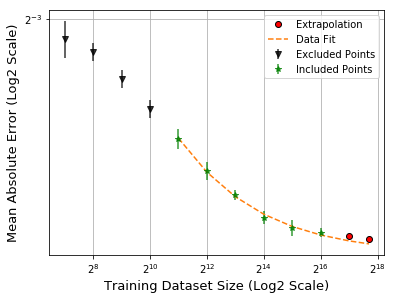

In [24]:
scr = scores_te.copy()
# scr = scores_te.copy().iloc[:-5, :]

# plot_args['figsize'] = (10, 8)
plot_args['figsize'] = (6, 4.5)

n_pnts_ext = 2 # Number of points to extrapolate to
n_pnts_fit = 6 # Number of points to use for curve fitting starting from the largest size

tot_pnts = len(scr['tr_size'])
m0 = tot_pnts - n_pnts_ext # The adjusted number of available Lc points
shard_min_idx = m0 - n_pnts_fit
    
# p_et = 2 # Number of points to extrapolate to
# tot_pnts = len(scr['tr_size'])
# m0 = tot_pnts - p_et

print('tot_pnts', tot_pnts)
# min_points = 3 # 3 points doesn't work
# min_pnts = 4 # min points to use in the fit
# max_pnts = 9
# max_pnts = tot_pnts


# shard_min_idx = 0 if tot_pnts < n_pnts_fit else tot_pnts - n_pnts_fit


# n_pnts = 6 # Number of points to use for curve fitting
# shard_min_idx = tot_pnts - n_pnts
# shard_min_idx = m0 - n_pnts

ax = None

# Plot of all the points
ax = lrn_crv_plot.plot_lrn_crv_new(
        x = scr['tr_size'][0:shard_min_idx], y = scr['median'][0:shard_min_idx], yerr = scr['std'][0:shard_min_idx],
        ax=ax, ls='', marker='v', alpha=0.8, color='k',
        **plot_args, label='Excluded Points')

# Plot of all the points
ax = lrn_crv_plot.plot_lrn_crv_new(
        x = scr['tr_size'][shard_min_idx:m0], y = scr['median'][shard_min_idx:m0], yerr = scr['std'][shard_min_idx:m0],
        ax=ax, ls='', marker='*', alpha=0.8, color='g',
        **plot_args, label='Included Points')

# Extrapolation
ax, _, mae_et = lrn_crv_plot.lrn_crv_power_law_extrapolate(
        x = scr['tr_size'][shard_min_idx:], y = scr['median'][shard_min_idx:],
        n_pnts_ext = n_pnts_ext,
        **plot_args, plot_raw_it=False, label_et='Extrapolation', ax=ax );

ax, _, mae_et = lrn_crv_plot.lrn_crv_power_law_extrapolate(
        x = scr['tr_size'][shard_min_idx:], y = scr['median'][shard_min_idx:],
        n_pnts_ext = n_pnts_ext,
        **plot_args, plot_raw_it=False, label_et='Extrapolation', ax=ax );

ax.legend(frameon=True, fontsize=10, loc='best')
# ax.set_xlim(min(scores_te['tr_size']), max(scores_te['tr_size'])+10000)
plt.savefig(save_fig_path/f'{src}_extrapolate.png')

print('GOF:', gof)
# print('RMSE:', rmse)
print('Fit MAE:', mae_et)

tot_pnts 12
GOF: {'mae_it': 0.0014346816626477187, 'mae_et': 0.005193952656533107}
Fit MAE: {'mae_it': 0.00029199789073781066, 'mae_et': 0.0003723282709072878}


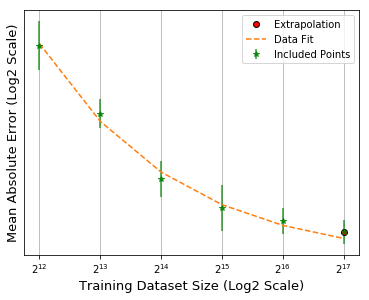

In [54]:
scr = scores_te.copy()
# scr = scores_te.copy().iloc[:-5, :]

# plot_args['figsize'] = (10, 8)
plot_args['figsize'] = (6, 4.5)

n_pnts_ext = 1 # Number of points to extrapolate to
n_pnts_fit = 6 # Number of points to use for curve fitting starting from the largest size

tot_pnts = len(scr['tr_size'])
m0 = tot_pnts - n_pnts_ext
shard_min_idx = m0 - n_pnts_fit
    
# p_et = 2 # Number of points to extrapolate to
# tot_pnts = len(scr['tr_size'])
# m0 = tot_pnts - p_et

print('tot_pnts', tot_pnts)
# min_points = 3 # 3 points doesn't work
# min_pnts = 4 # min points to use in the fit
# max_pnts = 9
# max_pnts = tot_pnts


# shard_min_idx = 0 if tot_pnts < n_pnts_fit else tot_pnts - n_pnts_fit


# n_pnts = 6 # Number of points to use for curve fitting
# shard_min_idx = tot_pnts - n_pnts
# shard_min_idx = m0 - n_pnts

ax = None

# Plot of all the points
# ax = lrn_crv_plot.plot_lrn_crv_new(
#         x=scr['tr_size'], y=scr['median'], yerr=scr['std'],
#         ax=ax, ls='', marker='v', alpha=0.8, color='k',
#         **plot_args, label='Excluded Points')

# Plot of all the points
ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scr['tr_size'][shard_min_idx:m0], y=scr['median'][shard_min_idx:m0], yerr=scr['std'][shard_min_idx:m0],
        ax=ax, ls='', marker='*', alpha=0.8, color='g',
        **plot_args, label='Included Points')

# Extrapolation
drop_pnts = 1 # Number of points to drop at the end
ax, _, mae_et = lrn_crv_plot.lrn_crv_power_law_extrapolate(
        # x=scr['tr_size'][shard_min_idx:], y=scr['median'][shard_min_idx:],
        x=scr['tr_size'][shard_min_idx:-drop_pnts], y=scr['median'][shard_min_idx:-drop_pnts],
        n_pnts_ext=n_pnts_ext,
        **plot_args, plot_raw_it=False, label_et='Extrapolation', ax=ax );

ax.legend(frameon=True, fontsize=10, loc='best')
# ax.set_xlim(min(scores_te['tr_size']), max(scores_te['tr_size'])+10000)
plt.savefig(save_fig_path/f'{src}_extrapolate.png')

print('GOF:', gof)
# print('RMSE:', rmse)
print('Fit MAE:', mae_et)

# Fig 4a LC of GBDT and NN 

In [26]:
# lrn_crv_scores = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_cell/multi_seed_lgbm_100_trees/top6.lgb_reg.ge.dd.auc1_2019-12-2_h0-m23/lrn_crv_scores.csv'))
lrn_crv_scores = pd.read_csv(Path('/vol/ml/apartin/projects/LearningCurves/trn.top6/split_on_cell/nn_reg_ap/run_03/lrn_crv_scores.csv'))

In [ ]:
get_xy(scores=lrn_crv_scores, shard_min_idx=0, cv_folds=1)

In [27]:
lrn_crv_scores

,metric,tr_size,set,fold0
0,mean_absolute_error,128,tr,0.131119
1,mean_absolute_error,256,tr,0.074808
2,mean_absolute_error,512,tr,0.056520
3,mean_absolute_error,1024,tr,0.046221
4,mean_absolute_error,2048,tr,0.026125
5,mean_absolute_error,4096,tr,0.035211
6,mean_absolute_error,8192,tr,0.046258
7,mean_absolute_error,16384,tr,0.047926
8,mean_absolute_error,32768,tr,0.046330
9,mean_absolute_error,65536,tr,0.050888
